# Download dataset and Configure Environment

In [19]:
!wget https://github.com/qtli/COMP7607-Fall2023/raw/441255379524b1297f707641ca4ca3944e3ef1ce/assignments/A2/conll2003.zip

--2023-12-14 09:19:45--  https://github.com/qtli/COMP7607-Fall2023/raw/441255379524b1297f707641ca4ca3944e3ef1ce/assignments/A2/conll2003.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/qtli/COMP7607-Fall2023/441255379524b1297f707641ca4ca3944e3ef1ce/assignments/A2/conll2003.zip [following]
--2023-12-14 09:19:46--  https://raw.githubusercontent.com/qtli/COMP7607-Fall2023/441255379524b1297f707641ca4ca3944e3ef1ce/assignments/A2/conll2003.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/zip]
Saving to: ‘conll2003.zip.1’

conll2003.zip.1     100%[===================>]

In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [3]:
!pip install keras-transformer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=82acf42f507ca6060bbab73d2a59818d5eb04672baf32668a491f7ad93465a0e
  Stored in directory: /root/.cache/pip/wheels/f2/cb/22/75a0ad376129177f7c95c0d91331a18f5368fd657f4035ba7c
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3943 sha256=e3126b5b81cf9c179521c9836984ed7b3fbc84e884e1a7885ff9ea620919ab08
  Stored in directory: /root/.cache/pip/wheels/82/32/c7/fd35d0d1b840a6c7cbd4343f808d10d0f7b87d271a4dbe796f
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4653 sha256=2177c5a73ed36c9548e12eaf694224d3784

In [4]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=3bcde2b59e1bed5a5a3e7912273922e2c1540bd07fe36e039e0b4f6953eff72f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
!unzip conll2003.zip

Archive:  conll2003.zip
  inflating: metadata                
  inflating: test.txt                
  inflating: train.txt               
  inflating: valid.txt               


In [6]:
import csv
from itertools import compress
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
import keras as keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import random
from seqeval.metrics import accuracy_score, f1_score, classification_report

In [7]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# 1. Data Loading and Preprocessing

## 1.1 Load data and Preprocess


*   Load the txt file
*   Build word2idx dictionary
*   Word Padding



In [8]:
def load_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ' ')
        for row in reader:
            data.append([row])

    sentences = []
    sentence = []
    entities = []
    tags = []

    for row in data:
        # extract first element of list.
        row = row[0]
        # TO DO: move to data reader.
        if len(row) > 0 and row[0] != '-DOCSTART-':
            sentence.append(row[0])
            tags.append(row[-1])
        if len(row) == 0 and len(sentence) > 0:
            # clean up sentence/tags.
            # remove white spaces.
            selector = [word != ' ' for word in sentence]
            sentence = list(compress(sentence, selector))
            tags = list(compress(tags, selector))
            # append if sentence length is still greater than zero..
            if len(sentence) > 0:
                sentences.append(sentence)
                entities.append(tags)
            sentence = []
            tags = []
    return sentences, entities

In [9]:

def preproces(word2idx, tag2idx, num_tags, train_sentences,train_labels, max_len):
    # Convert sentences and labels to numerical sequences
    X = X = [[word2idx.get(word.lower(), word2idx["UNKNOWN_TOKEN"]) for word in sentence] for sentence in train_sentences]
    X = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

    y = [[tag2idx[tag] for tag in labels] for labels in train_labels]
    y = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = tf.keras.utils.to_categorical(y, num_tags)

    return X, y

In [20]:
# Load the dataset
train_sentences, train_labels = load_file("train.txt")
valid_sentences, valid_labels = load_file("valid.txt")
test_sentences, test_labels = load_file("test.txt")

vocab = set()
tags = set()
for sentence in train_sentences:
    for word in sentence:
        vocab.add(word.lower())

word2idx = {}
if len(word2idx) == 0:
    word2idx["PADDING_TOKEN"] = len(word2idx)
    word2idx["UNKNOWN_TOKEN"] = len(word2idx)
for word in vocab:
    word2idx[word] = len(word2idx)

for labels in train_labels:
    for label in labels:
        tags.add(label)

tag2idx = {tag: i for i, tag in enumerate(tags)}

num_words = len(word2idx) + 1
num_tags = len(tag2idx)

max_len =max(len(sentence) for sentence in test_sentences)

train_X, train_y = preproces(word2idx, tag2idx, num_tags, train_sentences,  train_labels, max_len);
valid_X, valid_y = preproces(word2idx, tag2idx, num_tags, valid_sentences, valid_labels, max_len);
test_X, test_y = preproces(word2idx, tag2idx, num_tags, test_sentences, test_labels, max_len);

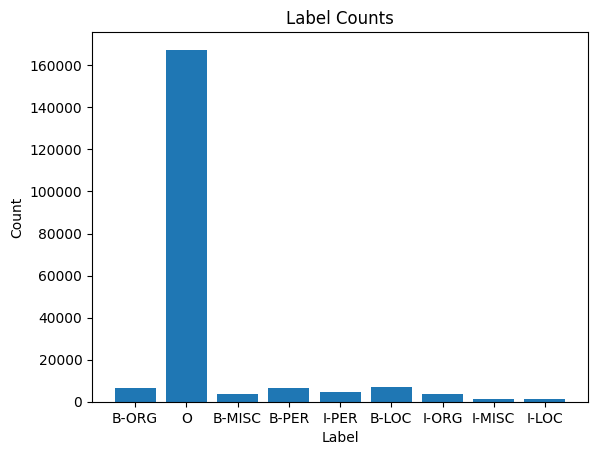

In [ ]:
label_counts = {}
for sentence in train_labels:
    for label in sentence:
        if label  not in label_counts:
          label_counts[label] = 0
        else:
          label_counts[label] += 1

# Plot histgram
x = np.arange(len(label_counts))
y = label_counts.values()

plt.bar(x, y)
plt.xticks(x, label_counts.keys())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()

In [11]:
def predict(model,test_sentences):
    # Convert test sentences to numerical sequences
    test_sequences = [[word2idx.get(word.lower(), 1) for word in sentence] for sentence in test_sentences]
    test_sequences = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=test_sequences, padding='post' , value=0)

    # Make predictions
    predictions = model.predict(test_sequences)
    # print(predictions)
    predicted_tags = tf.argmax(predictions, axis=-1).numpy()

    # Convert predicted tags back to labels
    predicted_labels = [[list(tag2idx.keys())[tag] for tag in tags] for tags in predicted_tags]

    return predicted_labels
def test_seqeval(true_labels,predicted_labels):
    # True labels Padding
    padded_true_labels = tf.keras.preprocessing.sequence.pad_sequences(true_labels, maxlen=max_len, padding='post', value='O',dtype=object)
    padded_true_labels = padded_true_labels.tolist()

    accuracy = accuracy_score(padded_true_labels, predicted_labels)
    f1 = f1_score(padded_true_labels, predicted_labels)
    report = classification_report(padded_true_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:")
    print(report)


# 1.LSTM

## 1.1 LSTM Model Training and Testing

In [ ]:
class LSTMModel():
  def __init__(self,num_words,max_len):
    # Define the model
    input_layer = Input(shape=(None,))
    embedding_layer = Embedding(input_dim=num_words, output_dim=60, input_length=max_len)(input_layer)
    lstm_layer = LSTM(units=50, return_sequences=True, dropout=0.5)(embedding_layer)
    output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm_layer)
    self.model = Model(input_layer, output_layer)
    self.model.summary()
  def train(self, train_X, train_y, valid_X, valid_y):

    # Model saving path
    model_path = 'lstm_model.h5'

    # early stop function
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
    # ModelCheckpoint
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    # Compile and train the model
    self.model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


    print(np.array(train_X).shape)
    print(np.array(train_y).shape)

    print(np.array(test_X).shape)
    print(np.array(test_y).shape)

    history = self.model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop, checkpoint])


    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

  def test(self, test_X, test_y):
    scores = self.model.evaluate(test_X, test_y, verbose=0)
    print("Test accuracy:", scores[1])

In [ ]:
lstm_model=LSTMModel(num_words,max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 60)          1260660   
                                                                 
 lstm (LSTM)                 (None, None, 50)          22200     
                                                                 
 time_distributed (TimeDist  (None, None, 9)           459       
 ributed)                                                        
                                                                 
Total params: 1283319 (4.90 MB)
Trainable params: 1283319 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(14039, 124)
(14039, 124, 9)
(3453, 124)
(3453, 124, 9)
Epoch 1/20
439/439 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9763
Epoch 1: val_accuracy improved from -inf to 0.97874, saving model to lstm_model.h5
439/439 [==============================] - 51s 110ms/step - loss: 0.1878 - accuracy: 0.9763 - val_loss: 0.0813 - val_accuracy: 0.9787
Epoch 2/20
  1/439 [..............................] - ETA: 43s - loss: 0.0741 - accuracy: 0.9798

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


439/439 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9825
Epoch 2: val_accuracy improved from 0.97874 to 0.98336, saving model to lstm_model.h5
439/439 [==============================] - 50s 113ms/step - loss: 0.0584 - accuracy: 0.9825 - val_loss: 0.0579 - val_accuracy: 0.9834
Epoch 3/20
439/439 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9870
Epoch 3: val_accuracy improved from 0.98336 to 0.98627, saving model to lstm_model.h5
439/439 [==============================] - 50s 114ms/step - loss: 0.0427 - accuracy: 0.9870 - val_loss: 0.0485 - val_accuracy: 0.9863
Epoch 4/20
439/439 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9896
Epoch 4: val_accuracy improved from 0.98627 to 0.98885, saving model to lstm_model.h5
439/439 [==============================] - 48s 110ms/step - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.0405 - val_accuracy: 0.9888
Epoch 5/20
439/439 [==============================] - ETA: 0s -

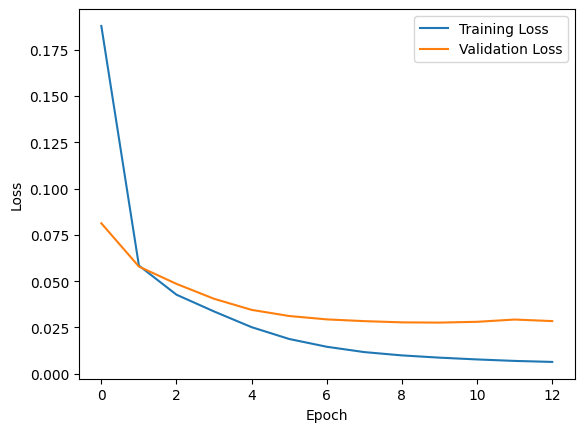

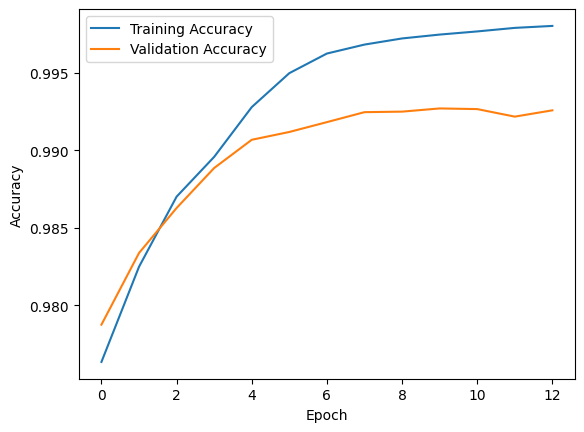

In [ ]:
lstm_model.train(train_X, train_y, valid_X, valid_y)

In [ ]:
lstm_model.test(test_X,test_y)

Test accuracy: 0.9905972480773926


In [ ]:
# Seqeval on train.txt
lstm_predicted_train_labels= predict(lstm_model.model,train_sentences)
test_seqeval(train_labels,lstm_predicted_train_labels)

439/439 [==============================] - 9s 18ms/step
Accuracy: 0.9987327927501499
F1 Score: 0.9236858638743456
Classification Report:
              precision    recall  f1-score   support

         LOC       0.92      0.95      0.93      7140
        MISC       0.85      0.88      0.87      3438
         ORG       0.86      0.90      0.88      6321
         PER       0.99      0.99      0.99      6600

   micro avg       0.91      0.94      0.92     23499
   macro avg       0.90      0.93      0.92     23499
weighted avg       0.91      0.94      0.92     23499



In [ ]:
# Seqeval on valid.txt
lstm_predicted_valid_labels= predict(lstm_model.model,valid_sentences)
test_seqeval(valid_labels,lstm_predicted_valid_labels)

102/102 [==============================] - 3s 33ms/step
Accuracy: 0.9925707196029777
F1 Score: 0.7043320704990941
Classification Report:
              precision    recall  f1-score   support

         LOC       0.77      0.78      0.78      1837
        MISC       0.70      0.64      0.67       922
         ORG       0.46      0.68      0.55      1341
         PER       0.88      0.73      0.80      1842

   micro avg       0.69      0.72      0.70      5942
   macro avg       0.70      0.71      0.70      5942
weighted avg       0.73      0.72      0.72      5942



In [ ]:
# Seqeval on test.txt
lstm_predicted_test_labels= predict(lstm_model.model,test_sentences)
test_seqeval(test_labels,lstm_predicted_test_labels)

108/108 [==============================] - 4s 35ms/step
Accuracy: 0.990597236624534
F1 Score: 0.5921120913336794
Classification Report:
              precision    recall  f1-score   support

         LOC       0.65      0.72      0.68      1668
        MISC       0.59      0.56      0.57       702
         ORG       0.40      0.56      0.47      1661
         PER       0.82      0.56      0.66      1617

   micro avg       0.58      0.61      0.59      5648
   macro avg       0.62      0.60      0.60      5648
weighted avg       0.62      0.61      0.60      5648



## 1.2 LSTM Model Optimization

In [ ]:
import keras.backend as K
from hyperopt import hp, fmin, tpe, Trials, space_eval

# Search space
space = {
    'num_words':num_words,
    'output_dim': hp.choice('output_dim', [50,100]),
    'units': hp.choice('units', [50, 100]),
    'dropout': hp.uniform('dropout', 0.3, 0.5)
}

best_accuracy = 0.0
best_params = {}

# Objective function
def objective(params):
    num_words = params['num_words']
    output_dim = params['output_dim']
    units = params['units']
    dropout = params['dropout']

    # Build model
    input_layer = Input(shape=(None,))
    embedding_layer = Embedding(input_dim=num_words, output_dim=output_dim, input_length=max_len)(input_layer)
    lstm_layer = LSTM(units=units, return_sequences=True, dropout=dropout)(embedding_layer)
    output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm_layer)

    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Model saving path
    model_path = 'lstm_model.h5'

    # early stop function
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
    # ModelCheckpoint
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    # Model training
    history = model.fit(train_X, train_y, batch_size=64, epochs=8, validation_data=(valid_X, valid_y), callbacks=[early_stop, checkpoint])


    accuracy = model.evaluate(valid_X, valid_y, verbose=0)[1]
    # Print current iteration count
    objective.iteration += 1
    print("Bayes Optimization Iteration:", objective.iteration)
    # Clear the useage of RAM
    K.clear_session()
    return {'loss': -accuracy, 'status': 'ok'}

objective.iteration = 0
# Bayes optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Best parameters
best_params = space_eval(space, best)


print("Best Parameters:", best_params)
print("Best Accuracy:", -trials.best_trial['result']['loss'])

流式输出内容被截断，只能显示最后 5000 行内容。
220/220 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9968

Epoch 8: val_accuracy improved from 0.99118 to 0.99137, saving model to lstm_model.h5

220/220 [==============================] - 7s 30ms/step - loss: 0.0129 - accuracy: 0.9968 - val_loss: 0.0310 - val_accuracy: 0.9914

Bayes Optimization Iteration:
3
Epoch 1/8

220/220 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9754

Epoch 1: val_accuracy improved from -inf to 0.97866, saving model to lstm_model.h5

220/220 [==============================] - 28s 113ms/step - loss: 0.2239 - accuracy: 0.9754 - val_loss: 0.1200 - val_accuracy: 0.9787

Epoch 2/8

220/220 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9806

Epoch 2: val_accuracy improved from 0.97866 to 0.97922, saving model to lstm_model.h5

220/220 [==============================] - 12s 56ms/step - loss: 0.0800 - accuracy: 0.9806 - val_loss: 0.0715 - val_accuracy: 0.9792

E

* Since the resource limitation on colab, we implemented other optimization on the server. Here is a run-able optimization using Bayes Optimizer

In [12]:
# Define the model with optimal hyperparameters
input_layer = Input(shape=(None,))
embedding_layer = Embedding(input_dim=num_words, output_dim=100, input_length=max_len)(input_layer)
lstm_layer = LSTM(units=100, return_sequences=True, dropout=0.3163377384609918)(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm_layer)
lstm_optimal_model = Model(input_layer, output_layer)
lstm_optimal_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2101100   
                                                                 
 lstm (LSTM)                 (None, None, 100)         80400     
                                                                 
 time_distributed (TimeDist  (None, None, 9)           909       
 ributed)                                                        
                                                                 
Total params: 2182409 (8.33 MB)
Trainable params: 2182409 (8.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
lstm_optimal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model saving path
model_path = 'lstm_optimal_model.h5'

# early stop function
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
# ModelCheckpoint
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Model training
history = lstm_optimal_model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop, checkpoint])
lstm_optimal_model.fit(train_X,train_y)

Epoch 1/20
439/439 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9778
Epoch 1: val_accuracy improved from -inf to 0.98088, saving model to lstm_optimal_model.h5
439/439 [==============================] - 59s 93ms/step - loss: 0.1381 - accuracy: 0.9778 - val_loss: 0.0652 - val_accuracy: 0.9809
Epoch 2/20
  8/439 [..............................] - ETA: 3s - loss: 0.0564 - accuracy: 0.9823

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


436/439 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9852
Epoch 2: val_accuracy improved from 0.98088 to 0.98457, saving model to lstm_optimal_model.h5
439/439 [==============================] - 7s 16ms/step - loss: 0.0461 - accuracy: 0.9852 - val_loss: 0.0494 - val_accuracy: 0.9846
Epoch 3/20
438/439 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9892
Epoch 3: val_accuracy improved from 0.98457 to 0.98761, saving model to lstm_optimal_model.h5
439/439 [==============================] - 7s 16ms/step - loss: 0.0342 - accuracy: 0.9892 - val_loss: 0.0428 - val_accuracy: 0.9876
Epoch 4/20
439/439 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9929
Epoch 4: val_accuracy improved from 0.98761 to 0.98938, saving model to lstm_optimal_model.h5
439/439 [==============================] - 12s 28ms/step - loss: 0.0246 - accuracy: 0.9929 - val_loss: 0.0368 - val_accuracy: 0.9894
Epoch 5/20
438/439 [========================

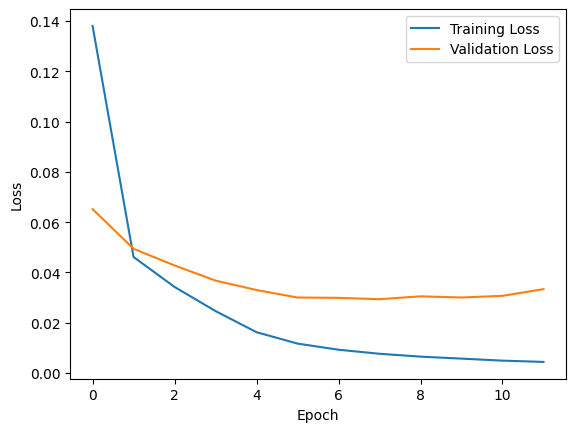

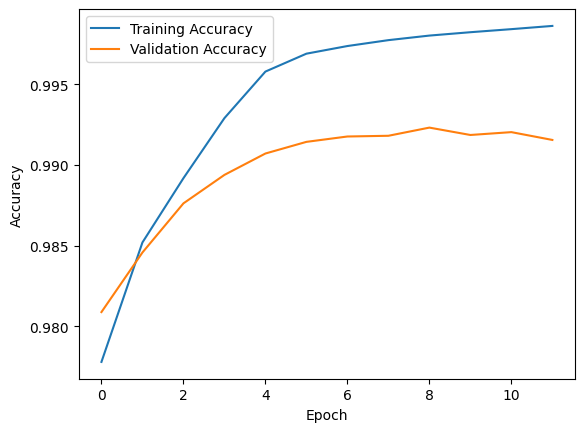

Test accuracy: 0.9895252585411072


In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
scores = lstm_optimal_model.evaluate(test_X, test_y, verbose=0)
print("Test accuracy:", scores[1])

In [ ]:
lstm_optimal_model = keras.models.load_model('lstm_optimal_model.h5')

In [16]:
# Seqeval on train.txt
O_lstm_predicted_train_labels= predict(lstm_optimal_model,train_sentences)
test_seqeval(train_labels,O_lstm_predicted_train_labels)

439/439 [==============================] - 3s 6ms/step
Accuracy: 0.9991234096721345
F1 Score: 0.9472422566604285
Classification Report:
              precision    recall  f1-score   support

         LOC       0.94      0.96      0.95      7140
        MISC       0.90      0.93      0.92      3438
         ORG       0.89      0.94      0.92      6321
         PER       0.99      0.99      0.99      6600

   micro avg       0.94      0.96      0.95     23499
   macro avg       0.93      0.95      0.94     23499
weighted avg       0.94      0.96      0.95     23499



In [17]:
# Seqeval on valid.txt
O_lstm_predicted_valid_labels= predict(lstm_optimal_model,valid_sentences)
test_seqeval(valid_labels,O_lstm_predicted_valid_labels)

102/102 [==============================] - 0s 4ms/step
Accuracy: 0.9914838709677419
F1 Score: 0.6828917969996807
Classification Report:
              precision    recall  f1-score   support

         LOC       0.73      0.78      0.75      1837
        MISC       0.67      0.65      0.66       922
         ORG       0.42      0.69      0.52      1341
         PER       0.86      0.71      0.78      1842

   micro avg       0.65      0.72      0.68      5942
   macro avg       0.67      0.71      0.68      5942
weighted avg       0.69      0.72      0.70      5942



In [18]:
# Seqeval on test.txt
O_lstm_predicted_test_labels= predict(lstm_optimal_model,test_sentences)
test_seqeval(test_labels,O_lstm_predicted_test_labels)

108/108 [==============================] - 0s 4ms/step
Accuracy: 0.9895252375213699
F1 Score: 0.5723520636499254
Classification Report:
              precision    recall  f1-score   support

         LOC       0.60      0.72      0.65      1668
        MISC       0.53      0.56      0.54       702
         ORG       0.38      0.60      0.47      1661
         PER       0.80      0.54      0.65      1617

   micro avg       0.54      0.61      0.57      5648
   macro avg       0.58      0.60      0.58      5648
weighted avg       0.59      0.61      0.58      5648



## 1.3 LSTM Model Output






In [ ]:
test_sentences,_=load_file("test.txt")
predicted_labels= predict(lstm_optimal_model,test_sentences)

108/108 [==============================] - 1s 5ms/step


In [ ]:
output = []
for i in range(len(test_sentences)):
  index = 0
  sentence = test_sentences[i]
  label = predicted_labels[i]
  for j in range(len(sentence)):
    line = []
    line.append(sentence[j])
    line.append(label[j])
    output.append(line)

with open("3036197134.lstm.test.txt", 'w') as file:
        for line in output:
          for word in line:
            file.write(word + ' ')
          file.write('\n')

# 2.Transformer

## 2.1 Transformer Model Training and Testing

In [ ]:
class TransfomerModel():
  def __init__(self,num_words,max_len):
    # Define the model
    # Input layer
    input_layer = Input(shape=(None,))
    # Embedding layer
    embedding_layer = Embedding(input_dim=num_words, output_dim=60, input_length=max_len)(input_layer)

    # Transformer Encoder layer
    encoder_output = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(embedding_layer, embedding_layer)
    encoder_output = tf.keras.layers.Dropout(0.5)(encoder_output)
    encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embedding_layer + encoder_output)
    encoder_output = tf.keras.layers.Dense(64, activation="relu")(encoder_output)

    # Output layer
    output_layer = TimeDistributed(Dense(9, activation="softmax"))(encoder_output)

    # Create the model
    self.model = Model(input_layer, output_layer)
    self.model.summary()

  def train(self, train_X, train_y, valid_X, valid_y):

    # Model saving path
    model_path = 'transformer_model.h5'

    # early stop function
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
    # ModelCheckpoint
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    # Compile and train the model
    self.model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


    print(np.array(train_X).shape)
    print(np.array(train_y).shape)

    print(np.array(test_X).shape)
    print(np.array(test_y).shape)

    history = self.model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop, checkpoint])


    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

  def test(self, test_X, test_y):
    scores = self.model.evaluate(test_X, test_y, verbose=0)
    print("Test accuracy:", scores[1])

In [ ]:
transformer_model=TransfomerModel(num_words,max_len)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, None, 60)             1260660   ['input_5[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, None, 60)             124476    ['embedding_4[0][0]',         
 iHeadAttention)                                                     'embedding_4[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, None, 60)             0         ['multi_head_attention[0

(14039, 124)
(14039, 124, 9)
(3453, 124)
(3453, 124, 9)
Epoch 1/20
439/439 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960
Epoch 1: val_accuracy improved from -inf to 0.98911, saving model to transformer_model.h5
439/439 [==============================] - 150s 336ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0419 - val_accuracy: 0.9891
Epoch 2/20
439/439 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9968
Epoch 2: val_accuracy improved from 0.98911 to 0.99030, saving model to transformer_model.h5
439/439 [==============================] - 165s 376ms/step - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.0421 - val_accuracy: 0.9903
Epoch 3/20
439/439 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9974
Epoch 3: val_accuracy did not improve from 0.99030
439/439 [==============================] - 175s 400ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.0465 - val_accuracy: 0.9895
Epoch 4/20
439/43

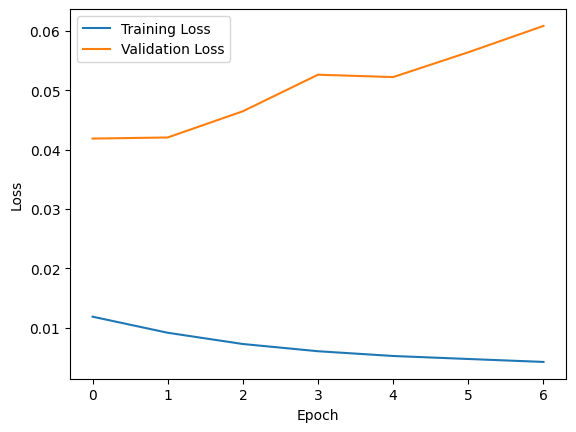

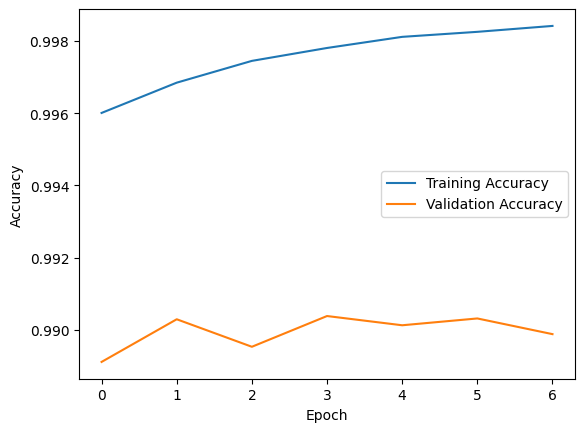

In [ ]:
transformer_model.train(train_X, train_y, valid_X, valid_y)

In [ ]:
transformer_model.test(test_X,test_y)

Test accuracy: 0.9873836040496826


In [ ]:
# Seqeval on train.txt
transformer_predicted_train_labels= predict(transformer_model.model,train_sentences)
test_seqeval(train_labels,transformer_predicted_train_labels)

439/439 [==============================] - 50s 113ms/step
Accuracy: 0.998908570365043
F1 Score: 0.9373851294903927
Classification Report:
              precision    recall  f1-score   support

         LOC       0.95      0.98      0.96      7140
        MISC       0.90      0.94      0.92      3438
         ORG       0.85      0.92      0.88      6321
         PER       0.97      0.98      0.97      6600

   micro avg       0.92      0.95      0.94     23499
   macro avg       0.92      0.95      0.93     23499
weighted avg       0.92      0.95      0.94     23499



In [ ]:
# Seqeval on valid.txt
transformer_predicted_valid_labels= predict(transformer_model.model,valid_sentences)
test_seqeval(valid_labels,transformer_predicted_valid_labels)

102/102 [==============================] - 16s 152ms/step
Accuracy: 0.9898833746898263
F1 Score: 0.6281092629330077
Classification Report:
              precision    recall  f1-score   support

         LOC       0.51      0.85      0.64      1837
        MISC       0.71      0.69      0.70       922
         ORG       0.57      0.64      0.60      1341
         PER       0.62      0.58      0.60      1842

   micro avg       0.57      0.69      0.63      5942
   macro avg       0.60      0.69      0.63      5942
weighted avg       0.59      0.69      0.63      5942



In [ ]:
# Seqeval on test.txt
transformer_predicted_test_labels= predict(transformer_model.model,test_sentences)
test_seqeval(test_labels,transformer_predicted_test_labels)

108/108 [==============================] - 13s 116ms/step
Accuracy: 0.9873835748250703
F1 Score: 0.4985047846889952
Classification Report:
              precision    recall  f1-score   support

         LOC       0.35      0.84      0.50      1668
        MISC       0.60      0.65      0.62       702
         ORG       0.53      0.57      0.55      1661
         PER       0.43      0.33      0.37      1617

   micro avg       0.43      0.59      0.50      5648
   macro avg       0.48      0.60      0.51      5648
weighted avg       0.46      0.59      0.49      5648



## 2.2 Transformer Model Optimization

In [ ]:
import optuna

def Tobjective(trial):
    # Define the hyperparameter search space
    key_dim = trial.suggest_int("key_dim", 32, 128)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Create the model with the suggested hyperparameters
    # Input layer
    input_layer = Input(shape=(None,))
    # Embedding layer
    embedding_layer = Embedding(input_dim=num_words, output_dim=60, input_length=max_len)(input_layer)

    # Transformer Encoder layer
    encoder_output = tf.keras.layers.MultiHeadAttention(8, key_dim)(embedding_layer, embedding_layer)
    encoder_output = tf.keras.layers.Dropout(dropout_rate)(encoder_output)
    encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embedding_layer + encoder_output)
    encoder_output = tf.keras.layers.Dense(64, activation="relu")(encoder_output)

    # Output layer
    output_layer = TimeDistributed(Dense(9, activation="softmax"))(encoder_output)
    model = Model(input_layer, output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    # early stop function
    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model and return the validation accuracy
    history = model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop], verbose=0)
    return history.history["val_accuracy"][-1]

# Create an Optuna study
study = optuna.create_study(direction="maximize")
# Run the hyperparameter optimization
study.optimize(Tobjective, n_trials=10)

# Print the best hyperparameters and validation accuracy
best_params = study.best_params
best_val_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_val_accuracy)



[I 2023-12-13 05:40:12,523] A new study created in memory with name: no-name-c38d57e3-3d3c-4844-87e0-ce32886d7bd0
<ipython-input-11-8150ba6c1dd9>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-11-8150ba6c1dd9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


Epoch 12: early stopping


[I 2023-12-13 05:42:05,386] Trial 0 finished with value: 0.9911017417907715 and parameters: {'key_dim': 101, 'dropout_rate': 0.18720479518301836, 'learning_rate': 0.00186106170560083}. Best is trial 0 with value: 0.9911017417907715.


Epoch 8: early stopping


[I 2023-12-13 05:43:46,574] Trial 1 finished with value: 0.9901365041732788 and parameters: {'key_dim': 110, 'dropout_rate': 0.17815024027996862, 'learning_rate': 0.00029666056110614643}. Best is trial 0 with value: 0.9911017417907715.


Epoch 7: early stopping


[I 2023-12-13 05:44:58,430] Trial 2 finished with value: 0.99025559425354 and parameters: {'key_dim': 71, 'dropout_rate': 0.4016353283644556, 'learning_rate': 0.0006202312935260395}. Best is trial 0 with value: 0.9911017417907715.


Epoch 8: early stopping


[I 2023-12-13 05:45:59,034] Trial 3 finished with value: 0.9915905594825745 and parameters: {'key_dim': 37, 'dropout_rate': 0.36720255776972865, 'learning_rate': 0.009085550934106287}. Best is trial 3 with value: 0.9915905594825745.


Epoch 5: early stopping


[I 2023-12-13 05:47:10,240] Trial 4 finished with value: 0.990114152431488 and parameters: {'key_dim': 51, 'dropout_rate': 0.3863979604362112, 'learning_rate': 0.0009061569353468614}. Best is trial 3 with value: 0.9915905594825745.


Epoch 7: early stopping


[I 2023-12-13 05:48:13,945] Trial 5 finished with value: 0.9856029748916626 and parameters: {'key_dim': 102, 'dropout_rate': 0.12518256930946997, 'learning_rate': 0.0004943937758745368}. Best is trial 3 with value: 0.9915905594825745.


Epoch 14: early stopping


[I 2023-12-13 05:50:16,004] Trial 6 finished with value: 0.9905732274055481 and parameters: {'key_dim': 92, 'dropout_rate': 0.3694166425406544, 'learning_rate': 0.001601689760753012}. Best is trial 3 with value: 0.9915905594825745.


Epoch 7: early stopping


[I 2023-12-13 05:51:17,350] Trial 7 finished with value: 0.9885682463645935 and parameters: {'key_dim': 81, 'dropout_rate': 0.16860625780045582, 'learning_rate': 0.000354604379610949}. Best is trial 3 with value: 0.9915905594825745.


Epoch 7: early stopping


[I 2023-12-13 05:52:36,393] Trial 8 finished with value: 0.9900918006896973 and parameters: {'key_dim': 49, 'dropout_rate': 0.1275731636642818, 'learning_rate': 0.0013377956940912683}. Best is trial 3 with value: 0.9915905594825745.


Epoch 7: early stopping


[I 2023-12-13 05:53:36,297] Trial 9 finished with value: 0.9876997470855713 and parameters: {'key_dim': 77, 'dropout_rate': 0.3814648571659979, 'learning_rate': 0.0003878767822144928}. Best is trial 3 with value: 0.9915905594825745.


Best Hyperparameters: {'key_dim': 37, 'dropout_rate': 0.36720255776972865, 'learning_rate': 0.009085550934106287}
Best Validation Accuracy: 0.9915905594825745


Epoch 5: early stopping


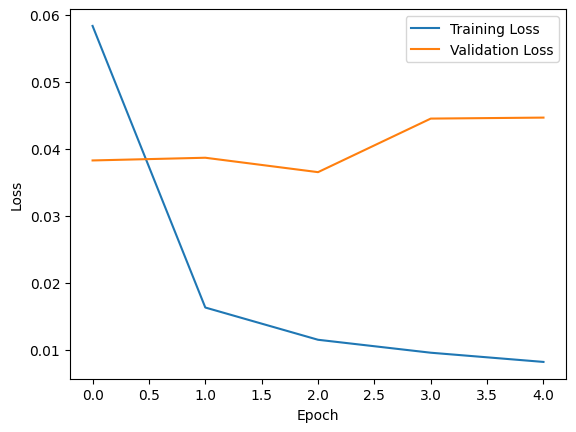

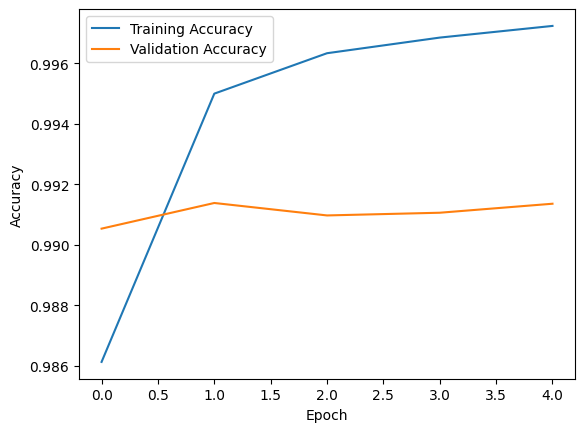

In [ ]:
# Define the model with optimal hyperparameters
# Input layer
input_layer = Input(shape=(None,))
# Embedding layer
embedding_layer = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_layer)

# Transformer Encoder layer

encoder_output = tf.keras.layers.MultiHeadAttention(8, 37)(embedding_layer, embedding_layer)
encoder_output = tf.keras.layers.Dropout(0.36)(encoder_output)
encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embedding_layer + encoder_output)
encoder_output = tf.keras.layers.Dense(64, activation="relu")(encoder_output)
# Output layer
output_layer = TimeDistributed(Dense(9, activation="softmax"))(encoder_output)
transformer_optimal_model = Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(0.009085550934106287)
# early stop function
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
transformer_optimal_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model and return the validation accuracy
history = transformer_optimal_model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop], verbose=0)
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
scores = transformer_optimal_model.evaluate(test_X, test_y, verbose=0)
print("Test accuracy:", scores[1])

Test accuracy: 0.9900833964347839


In [ ]:
# Seqeval on train.txt
O_transformer_predicted_train_labels= predict(transformer_optimal_model,train_sentences)
test_seqeval(train_labels,O_transformer_predicted_train_labels)

439/439 [==============================] - 40s 90ms/step
Accuracy: 0.9979308791867815
F1 Score: 0.8915207619204008
Classification Report:
              precision    recall  f1-score   support

         LOC       0.91      0.96      0.93      7140
        MISC       0.82      0.92      0.87      3438
         ORG       0.78      0.87      0.82      6321
         PER       0.91      0.95      0.93      6600

   micro avg       0.86      0.92      0.89     23499
   macro avg       0.86      0.92      0.89     23499
weighted avg       0.86      0.92      0.89     23499



In [ ]:
# Seqeval on valid.txt
O_transformer_predicted_valid_labels= predict(transformer_optimal_model,valid_sentences)
test_seqeval(valid_labels,O_transformer_predicted_valid_labels)

102/102 [==============================] - 10s 100ms/step
Accuracy: 0.9913573200992556
F1 Score: 0.6667220192627034
Classification Report:
              precision    recall  f1-score   support

         LOC       0.83      0.82      0.83      1837
        MISC       0.73      0.72      0.73       922
         ORG       0.59      0.61      0.60      1341
         PER       0.52      0.56      0.54      1842

   micro avg       0.66      0.68      0.67      5942
   macro avg       0.67      0.68      0.67      5942
weighted avg       0.66      0.68      0.67      5942



In [ ]:
# Seqeval on test.txt
O_transformer_predicted_test_labels= predict(transformer_optimal_model,test_sentences)
test_seqeval(test_labels,O_transformer_predicted_test_labels)

108/108 [==============================] - 11s 99ms/step
Accuracy: 0.9900834244182245
F1 Score: 0.5434455935649254
Classification Report:
              precision    recall  f1-score   support

         LOC       0.76      0.76      0.76      1668
        MISC       0.62      0.64      0.63       702
         ORG       0.58      0.51      0.54      1661
         PER       0.28      0.31      0.29      1617

   micro avg       0.54      0.54      0.54      5648
   macro avg       0.56      0.56      0.56      5648
weighted avg       0.55      0.54      0.55      5648



## 2.3 Transformer Model Output

In [ ]:
predicted_labels= predict(transformer_optimal_model,test_sentences)

108/108 [==============================] - 8s 73ms/step


In [ ]:
output = []
for i in range(len(test_sentences)):
  index = 0
  sentence = test_sentences[i]
  label = predicted_labels[i]
  for j in range(len(sentence)):
    line = []
    line.append(sentence[j])
    line.append(label[j])
    output.append(line)

with open("3036197134.transformer.test.txt", 'w') as file:
        for line in output:
          for word in line:
            file.write(word + ' ')
          file.write('\n')

# 3. Glove + LSTM

In [23]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-14 09:20:48--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-14 09:20:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2023-12-14 09:23:28 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [24]:
glove_path = 'glove.6B.50d.txt'
embedding_dim = 50
embedding_matrix = np.zeros((num_words, embedding_dim))
# Load GloVe
with open(glove_path, encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    if word in word2idx:
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_matrix[word2idx[word]] = coefs

# Build model
input_layer = Input(shape=(None,))
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)
lstm_layer = LSTM(units=100, return_sequences=True, dropout=0.3163377384609918)(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm_layer)
glove_lstm_model = Model(input_layer, output_layer)
glove_lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          1050550   
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         60400     
                                                                 
 time_distributed_1 (TimeDi  (None, None, 9)           909       
 stributed)                                                      
                                                                 
Total params: 1111859 (4.24 MB)
Trainable params: 61309 (239.49 KB)
Non-trainable params: 1050550 (4.01 MB)
_________________________________________________________________


In [ ]:
glove_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model saving path
model_path = 'glove_lstm_model.h5'

# early stop function
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
# ModelCheckpoint
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Model training
history = glove_lstm_model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop, checkpoint])

Epoch 1/20
439/439 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9782
Epoch 1: val_accuracy improved from -inf to 0.98345, saving model to glove_lstm_model.h5
439/439 [==============================] - 67s 147ms/step - loss: 0.1329 - accuracy: 0.9782 - val_loss: 0.0613 - val_accuracy: 0.9835
Epoch 2/20
439/439 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9860
Epoch 2: val_accuracy improved from 0.98345 to 0.98715, saving model to glove_lstm_model.h5
439/439 [==============================] - 59s 134ms/step - loss: 0.0514 - accuracy: 0.9860 - val_loss: 0.0477 - val_accuracy: 0.9871
Epoch 3/20
439/439 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9885
Epoch 3: val_accuracy improved from 0.98715 to 0.98935, saving model to glove_lstm_model.h5
439/439 [==============================] - 46s 105ms/step - loss: 0.0415 - accuracy: 0.9885 - val_loss: 0.0405 - val_accuracy: 0.9894
Epoch 4/20
439/439 [=================

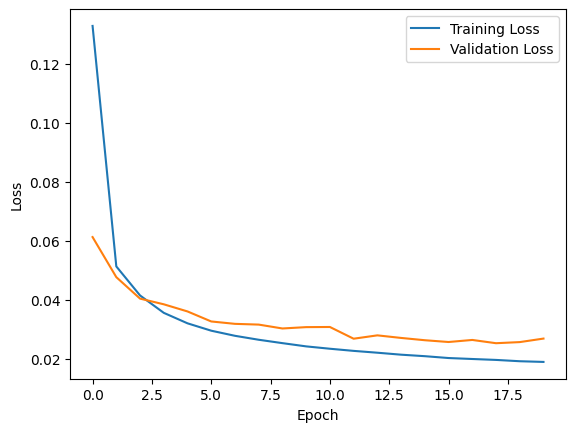

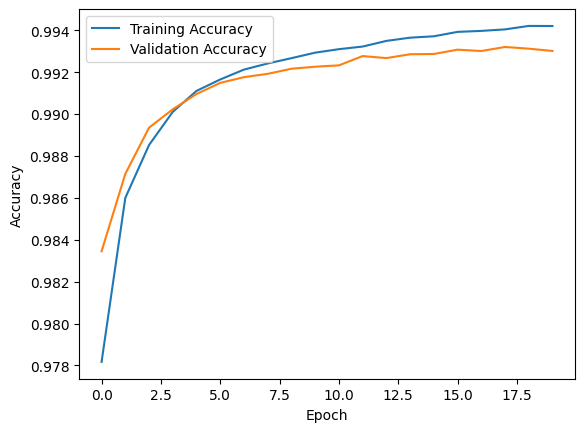

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Seqeval on train.txt
Glove_LSTM_predicted_train_labels= predict(glove_lstm_model,train_sentences)
test_seqeval(train_labels,Glove_LSTM_predicted_train_labels)

439/439 [==============================] - 15s 33ms/step
Accuracy: 0.996116233809503
F1 Score: 0.8164210797245995
Classification Report:
              precision    recall  f1-score   support

         LOC       0.87      0.89      0.88      7140
        MISC       0.79      0.67      0.72      3438
         ORG       0.70      0.70      0.70      6321
         PER       0.90      0.90      0.90      6600

   micro avg       0.82      0.81      0.82     23499
   macro avg       0.82      0.79      0.80     23499
weighted avg       0.82      0.81      0.82     23499



In [ ]:
# Seqeval on valid.txt
Glove_LSTM_predicted_valid_labels= predict(glove_lstm_model,valid_sentences)
test_seqeval(valid_labels,Glove_LSTM_predicted_valid_labels)

102/102 [==============================] - 3s 29ms/step
Accuracy: 0.993014888337469
F1 Score: 0.7414599065084502
Classification Report:
              precision    recall  f1-score   support

         LOC       0.86      0.83      0.85      1837
        MISC       0.77      0.61      0.68       922
         ORG       0.66      0.57      0.61      1341
         PER       0.83      0.68      0.75      1842

   micro avg       0.80      0.69      0.74      5942
   macro avg       0.78      0.68      0.72      5942
weighted avg       0.79      0.69      0.74      5942



In [ ]:
# Seqeval on test.txt
Glove_LSTM_predicted_test_labels= predict(glove_lstm_model,test_sentences)
test_seqeval(test_labels,Glove_LSTM_predicted_test_labels)

108/108 [==============================] - 4s 37ms/step
Accuracy: 0.9917649916388741
F1 Score: 0.6423243031016882
Classification Report:
              precision    recall  f1-score   support

         LOC       0.81      0.78      0.79      1668
        MISC       0.63      0.52      0.57       702
         ORG       0.64      0.50      0.56      1661
         PER       0.74      0.49      0.59      1617

   micro avg       0.72      0.58      0.64      5648
   macro avg       0.70      0.57      0.63      5648
weighted avg       0.72      0.58      0.64      5648



In [ ]:
predicted_labels= predict(glove_lstm_model,test_sentences)
output = []
for i in range(len(test_sentences)):
  index = 0
  sentence = test_sentences[i]
  label = predicted_labels[i]
  for j in range(len(sentence)):
    line = []
    line.append(sentence[j])
    line.append(label[j])
    output.append(line)

with open("3036197134.glove_lstm.test.txt", 'w') as file:
        for line in output:
          for word in line:
            file.write(word + ' ')
          file.write('\n')

108/108 [==============================] - 5s 42ms/step


# 4. Glove + Transfomer

Epoch 9: early stopping


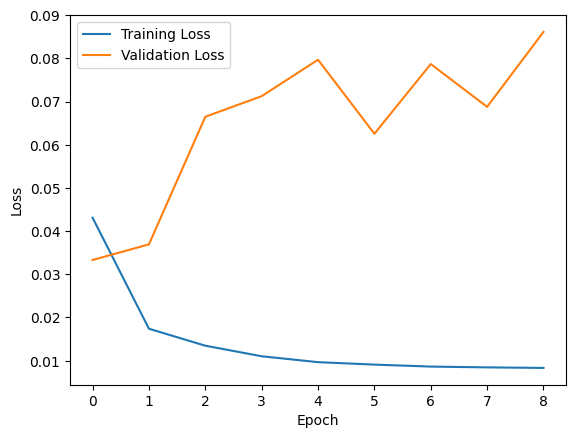

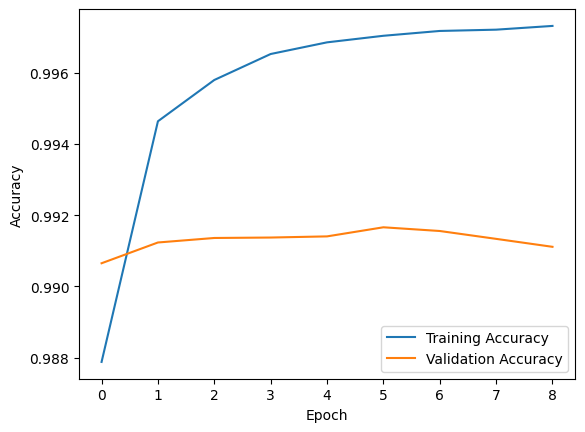

In [25]:
# Define the model with optimal hyperparameters
# Input layer
input_layer = Input(shape=(None,))
# Embedding layer with GloVe embeddings
embedding_layer = Embedding(input_dim=num_words, output_dim=50, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_layer)

# Transformer Encoder layer

encoder_output = tf.keras.layers.MultiHeadAttention(8, 37)(embedding_layer, embedding_layer)
encoder_output = tf.keras.layers.Dropout(0.36)(encoder_output)
encoder_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embedding_layer + encoder_output)
encoder_output = tf.keras.layers.Dense(64, activation="relu")(encoder_output)
# Output layer
output_layer = TimeDistributed(Dense(9, activation="softmax"))(encoder_output)
glove_transformer_model = Model(input_layer, output_layer)
optimizer = tf.keras.optimizers.Adam(0.009085550934106287)
# early stop function
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
glove_transformer_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model and return the validation accuracy
history = glove_transformer_model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(valid_X, valid_y), callbacks=[early_stop], verbose=0)
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Seqeval on train.txt
Glove_transformer_predicted_train_labels= predict(glove_transformer_model,train_sentences)
test_seqeval(train_labels,Glove_transformer_predicted_train_labels)

439/439 [==============================] - 2s 4ms/step
Accuracy: 0.9976442352984428
F1 Score: 0.8790088671583658
Classification Report:
              precision    recall  f1-score   support

         LOC       0.89      0.94      0.91      7140
        MISC       0.82      0.86      0.84      3438
         ORG       0.78      0.84      0.81      6321
         PER       0.91      0.95      0.93      6600

   micro avg       0.86      0.90      0.88     23499
   macro avg       0.85      0.90      0.87     23499
weighted avg       0.86      0.90      0.88     23499



In [27]:
# Seqeval on valid.txt
Glove_transformer_predicted_valid_labels= predict(glove_transformer_model,valid_sentences)
test_seqeval(valid_labels,Glove_transformer_predicted_valid_labels)

102/102 [==============================] - 1s 6ms/step
Accuracy: 0.9911141439205955
F1 Score: 0.6674818761463883
Classification Report:
              precision    recall  f1-score   support

         LOC       0.81      0.81      0.81      1837
        MISC       0.72      0.68      0.70       922
         ORG       0.59      0.56      0.57      1341
         PER       0.63      0.51      0.57      1842

   micro avg       0.69      0.64      0.67      5942
   macro avg       0.69      0.64      0.66      5942
weighted avg       0.69      0.64      0.66      5942



In [28]:
# Seqeval on test.txt
Glove_transformer_predicted_test_labels= predict(glove_transformer_model,test_sentences)
test_seqeval(test_labels,Glove_transformer_predicted_test_labels)

108/108 [==============================] - 1s 6ms/step
Accuracy: 0.9899432938165037
F1 Score: 0.5603631446783851
Classification Report:
              precision    recall  f1-score   support

         LOC       0.75      0.78      0.77      1668
        MISC       0.60      0.57      0.59       702
         ORG       0.61      0.47      0.53      1661
         PER       0.40      0.25      0.31      1617

   micro avg       0.62      0.51      0.56      5648
   macro avg       0.59      0.52      0.55      5648
weighted avg       0.59      0.51      0.54      5648



In [ ]:
predicted_labels= predict(glove_transformer_model,test_sentences)
output = []
for i in range(len(test_sentences)):
  index = 0
  sentence = test_sentences[i]
  label = predicted_labels[i]
  for j in range(len(sentence)):
    line = []
    line.append(sentence[j])
    line.append(label[j])
    output.append(line)

with open("3036197134.glove_transformer.test.txt", 'w') as file:
        for line in output:
          for word in line:
            file.write(word + ' ')
          file.write('\n')

108/108 [==============================] - 8s 76ms/step


# 5. BERT + LSTM

In [ ]:
from transformers import BertTokenizer, TFBertModel
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
input_ids = Input(shape=(max_len,), dtype=tf.int32)
attention_mask = Input(shape=(max_len,), dtype=tf.int32)

# Obtain the BERT embeddings
bert_outputs = bert_model(input_ids, attention_mask=attention_mask)

# Extract the BERT last hidden state
last_hidden_state = bert_outputs.last_hidden_state

# Build the rest of your model
embedding_dim = 50

# Input layer
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim)(input_layer)

# LSTM layer
lstm_layer = LSTM(units=100, return_sequences=True, dropout=0.5)(embedding_layer)

# Concatenate BERT embeddings and LSTM output
concatenated = tf.concat([last_hidden_state, lstm_layer], axis=-1)

# Output layer
output_layer = TimeDistributed(Dense(num_tags, activation="softmax"))(concatenated)

# Create the model
bert_lstm_model = Model([input_ids, attention_mask, input_layer], output_layer)
bert_lstm_model.summary()

# Compile the model
bert_lstm_model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = bert_lstm_model.fit([train_X, train_X, train_X], train_y, batch_size=32, epochs=10, validation_data=([valid_X, valid_X, valid_X], valid_y))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 124, 50)              1050550   ['input_8[0][0]']             
                                                                                            

439/439 [==============================] - 403s 823ms/step - loss: 0.1070 - accuracy: 0.9777 - val_loss: 0.0662 - val_accuracy: 0.9790
Epoch 2/10
439/439 [==============================] - 377s 860ms/step - loss: 0.0441 - accuracy: 0.9854 - val_loss: 0.0443 - val_accuracy: 0.9861
Epoch 3/10
439/439 [==============================] - 377s 859ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 4/10
439/439 [==============================] - 377s 859ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.0342 - val_accuracy: 0.9899
Epoch 5/10
439/439 [==============================] - 377s 859ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0303 - val_accuracy: 0.9911
Epoch 6/10
439/439 [==============================] - 377s 859ms/step - loss: 0.0125 - accuracy: 0.9963 - val_loss: 0.0320 - val_accuracy: 0.9914
Epoch 7/10
439/439 [==============================] - 376s 857ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0298 - val_accura

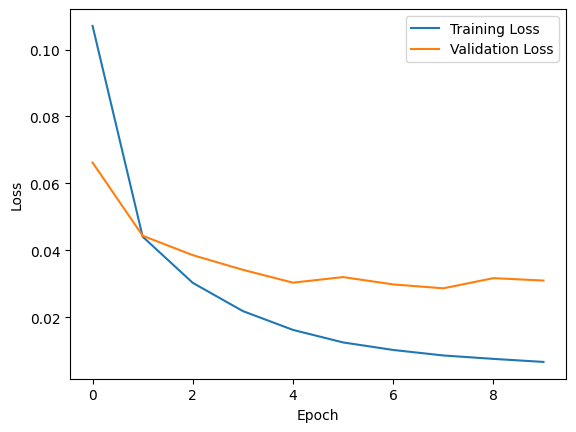

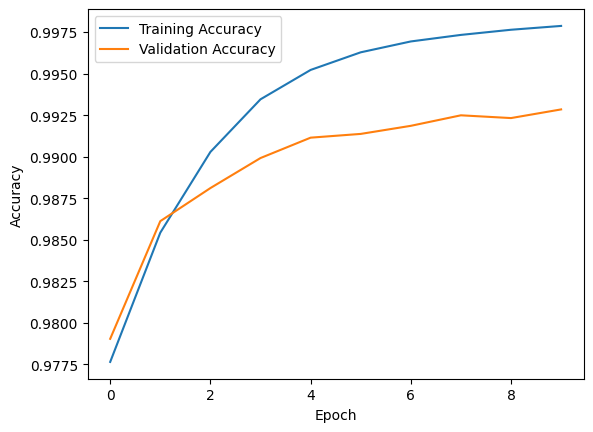

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def BERTpredict(model,test_sentences):
    # Convert test sentences to numerical sequences
    test_sequences = [[word2idx.get(word.lower(), 1) for word in sentence] for sentence in test_sentences]
    test_sequences = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len, sequences=test_sequences, padding='post' , value=0)

    # Make predictions
    predictions = model.predict([test_sequences,test_sequences,test_sequences])
    # print(predictions)
    predicted_tags = tf.argmax(predictions, axis=-1).numpy()

    # Convert predicted tags back to labels
    predicted_labels = [[list(tag2idx.keys())[tag] for tag in tags] for tags in predicted_tags]

    return predicted_labels

In [ ]:
# Seqeval on train.txt
BERT_LSTM_predicted_train_labels= BERTpredict(bert_lstm_model,train_sentences)
test_seqeval(train_labels,BERT_LSTM_predicted_train_labels)

439/439 [==============================] - 113s 244ms/step
Accuracy: 0.9986150332369046
F1 Score: 0.9187415881561238
Classification Report:
              precision    recall  f1-score   support

         LOC       0.93      0.93      0.93      7140
        MISC       0.86      0.85      0.86      3438
         ORG       0.84      0.91      0.87      6321
         PER       0.98      0.98      0.98      6600

   micro avg       0.91      0.93      0.92     23499
   macro avg       0.90      0.92      0.91     23499
weighted avg       0.91      0.93      0.92     23499



In [ ]:
# Seqeval on valid.txt
BERT_LSTM_predicted_valid_labels= BERTpredict(bert_lstm_model,valid_sentences)
test_seqeval(valid_labels,BERT_LSTM_predicted_valid_labels)

102/102 [==============================] - 25s 244ms/step
Accuracy: 0.9928461538461538
F1 Score: 0.7226338834624453
Classification Report:
              precision    recall  f1-score   support

         LOC       0.84      0.79      0.81      1837
        MISC       0.77      0.66      0.72       922
         ORG       0.47      0.70      0.56      1341
         PER       0.90      0.70      0.79      1842

   micro avg       0.72      0.72      0.72      5942
   macro avg       0.75      0.71      0.72      5942
weighted avg       0.77      0.72      0.73      5942



In [ ]:
# Seqeval on test.txt
BERT_LSTM_predicted_test_labels= BERTpredict(bert_lstm_model,test_sentences)
test_seqeval(test_labels,BERT_LSTM_predicted_test_labels)

108/108 [==============================] - 27s 245ms/step
Accuracy: 0.9905154937735302
F1 Score: 0.6046880507578428
Classification Report:
              precision    recall  f1-score   support

         LOC       0.72      0.72      0.72      1668
        MISC       0.63      0.56      0.59       702
         ORG       0.42      0.61      0.49      1661
         PER       0.84      0.52      0.64      1617

   micro avg       0.60      0.61      0.60      5648
   macro avg       0.65      0.60      0.61      5648
weighted avg       0.65      0.61      0.61      5648



In [ ]:
predicted_labels= BERT_LSTM_predicted_test_labels
output = []
for i in range(len(test_sentences)):
  index = 0
  sentence = test_sentences[i]
  label = predicted_labels[i]
  for j in range(len(sentence)):
    line = []
    line.append(sentence[j])
    line.append(label[j])
    output.append(line)

with open("3036197134.bert_lstm.test.txt", 'w') as file:
        for line in output:
          for word in line:
            file.write(word + ' ')
          file.write('\n')